# SPACEc: Dataframe Preprocessing

## Set up environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import numpy as np

# silencing warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import spacec as sp

2024-01-16 08:12:39.227494: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mgbckr/miniconda3/envs/yuqi-spacodex/lib/python3.10/site-packages/cv2/../../lib64:
2024-01-16 08:12:39.227528: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
root_path = pathlib.Path("..")

data_path = root_path / 'data' # where the data is stored

# where you want to store the output
output_dir = root_path / '_out'
output_dir.mkdir(exist_ok=True, parents=True)

out_fname = "tonsil"

## 2.1 Load data

Read and concatenate the csv files (outputs from the cell segmentation algorithms). 

In [5]:
#read in segmentation csv files
df_seg = sp.pp.pp_read_segdf(
    segfile_list = [
        data_path / "processed/cellseg/reg010_X01_Y01_Z01_compensated.csv", 
        data_path / "processed/cellseg/reg001_X01_Y01_Z01_compensated.csv"
    ],
    seg_method = 'cellseg',
    region_list =["reg010", "reg001"],
    meta_list = ["tonsillitis", "tonsil"]
)

#Get the shape of the data
print(df_seg.shape)

#See what it looks like
df_seg.head()

(52218, 71)


,cell_id,region,tile_num,x,y,z,x_tile,y_tile,area,DAPI,...,GranzymeB,IDO-1,CD45,CollagenIV,PD-L1,Arginase-1,GATA3,region_num,unique_region,condition
0,1.0,10.0,1.0,599.0,1721.0,1.0,599.0,1721.0,20.0,58.452089,...,0.000000,4.324554,18.868577,5.933131,12.849905,2.004022,11.934559,0,reg010,tonsillitis
1,2.0,10.0,1.0,2159.0,615.0,1.0,2159.0,615.0,74.0,86.372276,...,0.000000,2.926918,34.616144,5.589555,10.254221,2.166106,11.117285,0,reg010,tonsillitis
2,3.0,10.0,1.0,558.0,1027.0,1.0,558.0,1027.0,68.0,67.217662,...,0.020250,4.860737,22.324609,5.276936,11.147313,1.981664,7.081764,0,reg010,tonsillitis
3,4.0,10.0,1.0,1052.0,990.0,1.0,1052.0,990.0,147.0,48.907490,...,0.000000,3.813063,24.231576,3.899519,17.289386,2.361467,6.886369,0,reg010,tonsillitis
4,5.0,10.0,1.0,1008.0,2100.0,1.0,1008.0,2100.0,46.0,70.925956,...,0.162383,3.272036,43.777483,4.648866,9.633944,2.704003,6.731205,0,reg010,tonsillitis


# 2.2 Filter cells by DAPI intensity and area

Identify the lowest 1% for cell size and nuclear marker intensity to get a better idea of potential segmentation artifacts.

In [6]:
# print smallest 1% of cells by area
one_percent_area = np.percentile(df_seg.area, 1)
one_percent_area

27.0

In [7]:
# print smallest 1% of cells by DAPI intensity
one_percent_nuc = np.percentile(df_seg.DAPI, 1)
one_percent_nuc

0.0

If necessary filter the dataframe to remove too small objects or cells without a nucleus. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


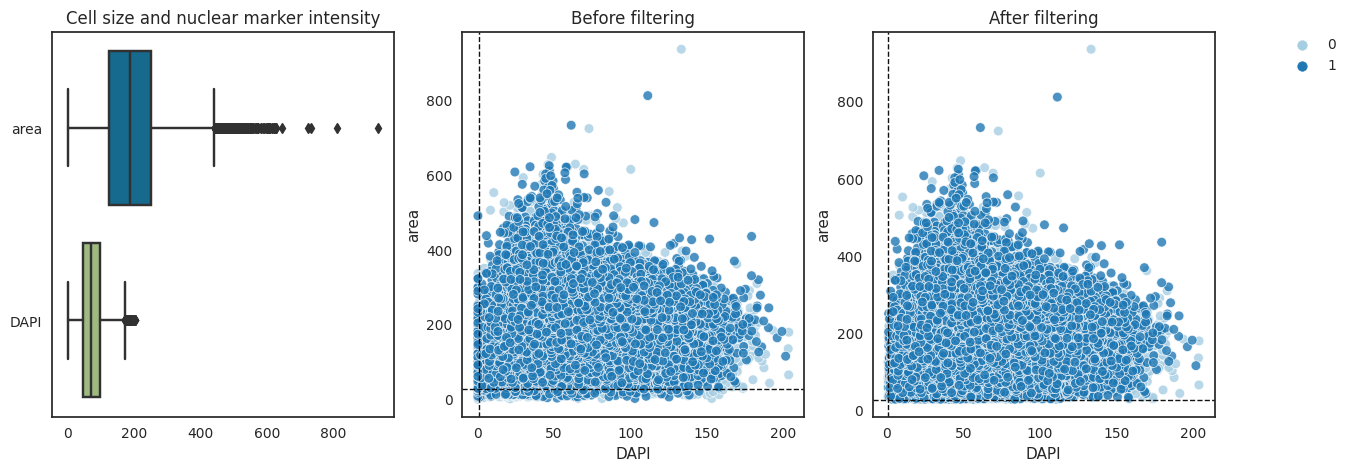

<Figure size 800x550 with 0 Axes>

Percentage of cells kept:  97.49703167490138 %


In [8]:
df_filt = sp.pp.pp_filter_data(
    df_seg, 
    nuc_thres=1,
    size_thres=one_percent_area,
    nuc_marker="DAPI",
    cell_size = "area",
    region_column = "region_num",
    color_by = "region_num",
    log_scale=False)

## 2.3 Normalize data

Normalize data with one of the four available methods (zscore as default)

In [9]:
df_filt.columns

Index(['cell_id', 'region', 'tile_num', 'x', 'y', 'z', 'x_tile', 'y_tile',
       'area', 'DAPI', 'FoxP3', 'HLA-DR', 'CD103', 'CHGA', 'EGFR', 'CD206',
       'GFAP', 'PD-1', 'BCL2', 'panCK', 'CD45RO', 'CD11b', 'CD56', 'CD163',
       'CD21', 'CD8', 'S100', 'Vimentin', 'PDGFRb', 'CCR7', 'CD57', 'CD34',
       'Synaptophysin', 'CD31', 'CXCR5', 'CD3', 'CD38', 'LAG3', 'CD25', 'CD16',
       'IL-10', 'Ki67', 'CLEC9A', 'p53', 'CD69', 'CD11c', 'CD68', 'Ox40',
       'aSMA', 'CD20', 'CD4', 'MUC-1', 'Podoplanin', 'CD45RA', 'CD15',
       'betaCatenin', 'PAX5', 'MCT', 'FAP', 'CD138', 'Tbet', 'GranzymeB',
       'IDO-1', 'CD45', 'CollagenIV', 'PD-L1', 'Arginase-1', 'GATA3',
       'region_num', 'unique_region', 'condition'],
      dtype='object')

In [10]:
# This is to normalize the data 
dfz = sp.pp.pp_format(
    data=df_filt, 
    list_out=['cell_id', 'tile_num', 'z', 'x_tile', 'y_tile'], 
    # in case of other segmentation methods: ['eccentricity', 'perimeter', 'convex_area', 'axis_major_length', 'axis_minor_length', "first_index", "filename", "label"]
    list_keep = ["DAPI",'x','y', 'area','region_num', 'region',"unique_region", 'condition'], # This is a list of meta information that you would like to keep but don't want to normalize
    method = "zscore") # choose from "zscore", "double_zscore", "MinMax", "ArcSin"
print(dfz.shape)

(50911, 66)


## 2.4 Remove noisy cells

This section is used to remove noisy cells. This is very important to ensure proper identification of the cells via clustering.

In [11]:
dfz.columns

Index(['FoxP3', 'HLA-DR', 'CD103', 'CHGA', 'EGFR', 'CD206', 'GFAP', 'PD-1',
       'BCL2', 'panCK', 'CD45RO', 'CD11b', 'CD56', 'CD163', 'CD21', 'CD8',
       'S100', 'Vimentin', 'PDGFRb', 'CCR7', 'CD57', 'CD34', 'Synaptophysin',
       'CD31', 'CXCR5', 'CD3', 'CD38', 'LAG3', 'CD25', 'CD16', 'IL-10', 'Ki67',
       'CLEC9A', 'p53', 'CD69', 'CD11c', 'CD68', 'Ox40', 'aSMA', 'CD20', 'CD4',
       'MUC-1', 'Podoplanin', 'CD45RA', 'CD15', 'betaCatenin', 'PAX5', 'MCT',
       'FAP', 'CD138', 'Tbet', 'GranzymeB', 'IDO-1', 'CD45', 'CollagenIV',
       'PD-L1', 'Arginase-1', 'GATA3', 'DAPI', 'x', 'y', 'area', 'region_num',
       'region', 'unique_region', 'condition'],
      dtype='object')

In [12]:
# get the column index for the last marker 
col_num_last_marker = dfz.columns.get_loc('GATA3')
print(col_num_last_marker)

57


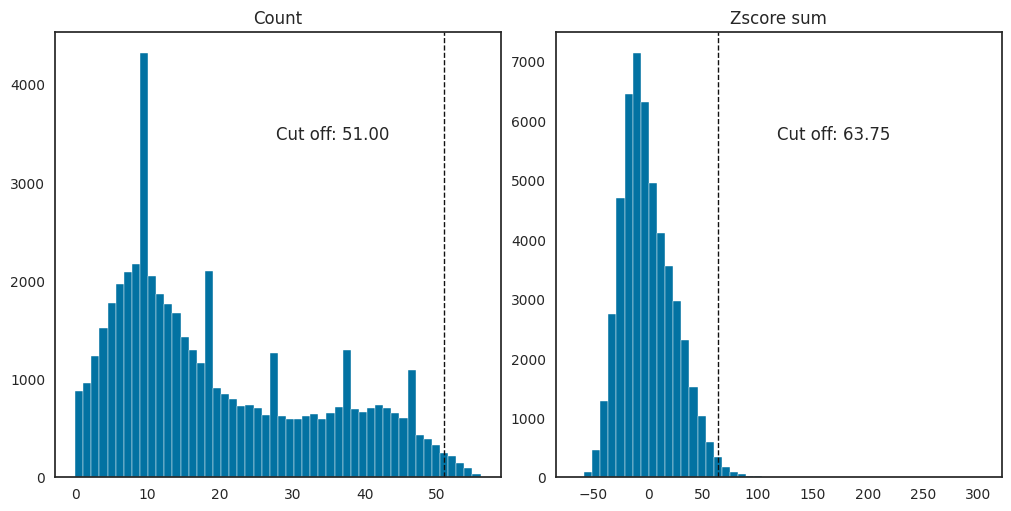

In [14]:
# This function helps to figure out what the cut-off should be
# This is to remove top 1 % of all cells that are highly expressive for all antibodies
sp.pl.pl_zcount_thres(dfz = dfz, 
                col_num = col_num_last_marker, # last antibody index
                cut_off=0.01, #top 1% of cells
                count_bin=50) 

This step removes the remaining noisy cells from the analysis

In [15]:
df_nn,cc = sp.pp.pp_remove_noise(
    df=dfz, 
    col_num=col_num_last_marker, # this is the column index that has the last protein feature
    z_count_thres=51, # number obtained from the function above
    z_sum_thres=63 # number obtained from the function above
)
print(df_nn.shape)

1.7000000000000002% cells are removed.
(50065, 66)


## 2.5 Save denoise data

#### Save as dataframe 

In [16]:
#Save the df as a backup. We strongly recommend the Anndata format for further analysis!
df_nn.to_csv(output_dir / "df_nn_demo.csv")

#### Save as anndata

In [17]:
# inspect which markers work, and drop the ones that did not work from the clustering step
# make an anndata to be compatible with the downstream clustering step
adata = sp.hf.hf_make_anndata(
    df_nn = df_nn,
    col_sum = col_num_last_marker, # this is the column index that has the last protein feature # the rest will go into obs
    nonFuncAb_list = [] # Remove the antibodies that are not working
)
adata

AnnData object with n_obs × n_vars = 50065 × 58
    obs: 'DAPI', 'x', 'y', 'area', 'region_num', 'region', 'unique_region', 'condition'

In [18]:
# save the anndata object to a file
adata.write_h5ad(output_dir / 'adata_nn_demo.h5ad')

## 2.6 Show the spatial distribution for size (Optional)

In [19]:
import pickle
with open(output_dir / 'overlay_tonsil1.pickle', 'rb') as f:
    overlay_data1 = pickle.load(f)

with open(output_dir / 'overlay_tonsil2.pickle', 'rb') as f:
    overlay_data2 = pickle.load(f)

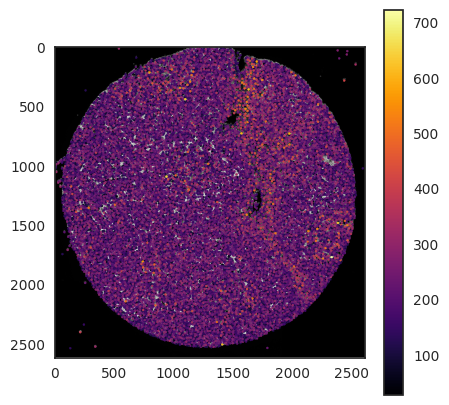

In [20]:
sp.pl.pl_coordinates_on_image(
    df = df_nn.loc[df_nn['unique_region'] == 'reg010',:], 
    overlay_data = overlay_data1, color='area',  
    scale=False, # whether to scale to 1 or not
    dot_size=2,
    convert_to_grey=True, 
    fig_width=5, fig_height=5)

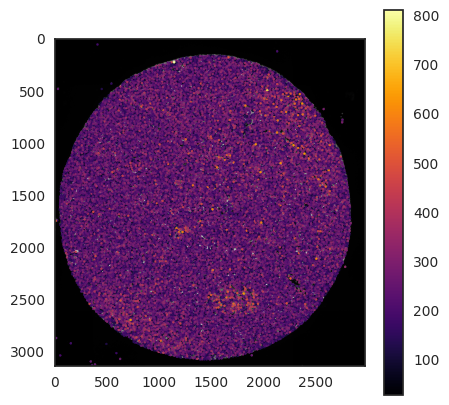

In [21]:
sp.pl.pl_coordinates_on_image(
    df = df_nn.loc[df_nn['unique_region'] == 'reg001',:], 
    overlay_data = overlay_data2, 
    color='area', 
    scale=False, # whether to scale to 1 or not
    dot_size=2,
    convert_to_grey=True, 
    fig_width=5, fig_height=5 )